# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler
from torch.optim.lr_scheduler import StepLR

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [32]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [45]:
print(data_size)
print(data_test.data.shape[0])
print(split)
data_train[0][0].shape

73257
26032
14651


torch.Size([3, 32, 32])

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [33]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [34]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [74]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs,
                scheduler = StepLR(optimizer, step_size = 1, gamma = 1.0)):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        scheduler.step()
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            indices = torch.argmax(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval(); # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: torch doesn't have a dedicated argmax function,
    #       but you can use torch.max instead (see the documentation).
    with torch.no_grad():
        correct_samples = 0;
        total_samples = 0;
        for i_step, (x, y) in enumerate(loader):
            prediction = model(x);    
            indices = torch.argmax(prediction, 1);
            correct_samples += torch.sum(indices == y);
            total_samples += y.shape[0];
            
        val_accuracy = float(correct_samples) / total_samples;
    return val_accuracy;

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 0.613803, Train accuracy: 0.814678, Val accuracy: 0.787114
Average loss: 0.613797, Train accuracy: 0.814678, Val accuracy: 0.787114
Average loss: 0.613810, Train accuracy: 0.814678, Val accuracy: 0.787114


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [9]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100 instead of 1
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
       )
nn_model.type(torch.FloatTensor)
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.202224, Train accuracy: 0.188889, Val accuracy: 0.198075
Average loss: 2.063288, Train accuracy: 0.235966, Val accuracy: 0.277387
Average loss: 1.891729, Train accuracy: 0.340085, Val accuracy: 0.393284
Average loss: 1.733636, Train accuracy: 0.411818, Val accuracy: 0.418674
Average loss: 1.690416, Train accuracy: 0.429564, Val accuracy: 0.418060


Добавьте слой с Batch Normalization

In [13]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before the non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(            
            Flattener(),
            nn.Linear(3*32*32, 100),
            torch.nn.BatchNorm1d(num_features = 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            torch.nn.BatchNorm1d(num_features = 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
         )
nn_model.type(torch.FloatTensor)
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.186098, Train accuracy: 0.237365, Val accuracy: 0.289332
Average loss: 2.033676, Train accuracy: 0.317715, Val accuracy: 0.353628
Average loss: 1.936005, Train accuracy: 0.371532, Val accuracy: 0.389188
Average loss: 1.865165, Train accuracy: 0.407296, Val accuracy: 0.431575
Average loss: 1.808866, Train accuracy: 0.429768, Val accuracy: 0.450208


Добавьте уменьшение скорости обучения по ходу тренировки.

In [46]:
# Learing rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(            
            Flattener(),
            nn.Linear(3*32*32, 100),
            torch.nn.BatchNorm1d(num_features = 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            torch.nn.BatchNorm1d(num_features = 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10)
         )
nn_model.type(torch.FloatTensor)
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = StepLR(optimizer, step_size = 2, gamma=0.5)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler)

Average loss: 2.178498, Train accuracy: 0.256595, Val accuracy: 0.332674
Average loss: 1.997874, Train accuracy: 0.371634, Val accuracy: 0.396628
Average loss: 1.913875, Train accuracy: 0.410606, Val accuracy: 0.423248
Average loss: 1.868563, Train accuracy: 0.429598, Val accuracy: 0.441608
Average loss: 1.835774, Train accuracy: 0.443897, Val accuracy: 0.448297


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [51]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        data_source (Dataset): dataset to sample from
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=SubsetSampler(indices));
    with torch.no_grad():
        predictions = []
        ground_truth = []
        for sample, label in loader:
            prediction = model(sample);
            label_predict = torch.argmax(prediction, 1);
            predictions = np.concatenate((predictions, label_predict));
            ground_truth = np.concatenate((ground_truth, label));
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))


## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

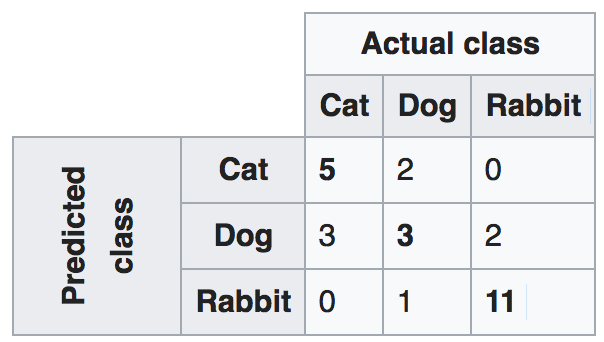

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

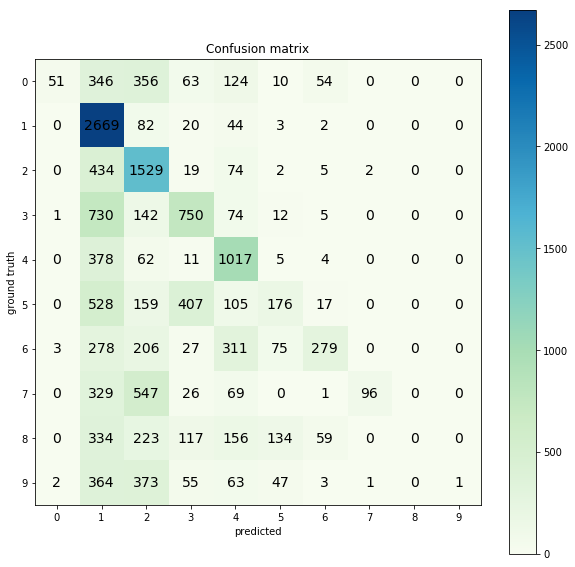

In [58]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.xlabel("predicted")
    plt.ylabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    for index, label in enumerate(ground_truth):
        confusion_matrix[int(label)][int(predictions[index])] += 1;
    # TODO: Implement filling the prediction matrix
    return confusion_matrix;

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

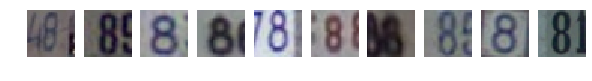

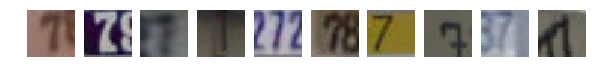

In [60]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    indices_for_image = []
    for index, label in enumerate(predictions):
        if (label == predicted_class) and (groud_truth[index] == gt_class):
            indices_for_image.append(val_indices[index]);
    
    visualize_images(indices_for_image, data);
    
visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на валидацонной выборке должна быть доведена до **60%**

За лучший результат в группе вы получите дополнительные баллы :)

In [67]:
# Experiment here!
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-3, amsgrad=False)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 20)

Average loss: 1.291788, Train accuracy: 0.593540, Val accuracy: 0.679885
Average loss: 0.915973, Train accuracy: 0.722588, Val accuracy: 0.740018
Average loss: 0.816764, Train accuracy: 0.755418, Val accuracy: 0.766364
Average loss: 0.779761, Train accuracy: 0.767771, Val accuracy: 0.761040
Average loss: 0.751713, Train accuracy: 0.775467, Val accuracy: 0.761723
Average loss: 0.730928, Train accuracy: 0.782599, Val accuracy: 0.751758
Average loss: 0.713667, Train accuracy: 0.788281, Val accuracy: 0.769709
Average loss: 0.707395, Train accuracy: 0.790158, Val accuracy: 0.771824
Average loss: 0.698813, Train accuracy: 0.791455, Val accuracy: 0.774896
Average loss: 0.688349, Train accuracy: 0.794902, Val accuracy: 0.784520
Average loss: 0.686587, Train accuracy: 0.795243, Val accuracy: 0.769436
Average loss: 0.673514, Train accuracy: 0.800942, Val accuracy: 0.767456
Average loss: 0.678768, Train accuracy: 0.796744, Val accuracy: 0.781858
Average loss: 0.670160, Train accuracy: 0.800447, V

In [72]:
nn_model_2 = nn.Sequential(            
            Flattener(),
            nn.Linear(3*32*32, 100),
            torch.nn.BatchNorm1d(num_features = 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10)
         )
nn_model.type(torch.FloatTensor)
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = torch.optim.Adam(nn_model_2.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4, amsgrad=False)
scheduler = StepLR(optimizer, step_size = 5, gamma=0.5)

loss_history, train_history, val_history = train_model(nn_model_2, train_loader, val_loader, loss, optimizer, 20, scheduler)

Average loss: 1.537585, Train accuracy: 0.517967, Val accuracy: 0.689646
Average loss: 1.014453, Train accuracy: 0.696942, Val accuracy: 0.739608
Average loss: 0.874440, Train accuracy: 0.737979, Val accuracy: 0.765955
Average loss: 0.798302, Train accuracy: 0.763079, Val accuracy: 0.773736
Average loss: 0.759436, Train accuracy: 0.773675, Val accuracy: 0.794075
Average loss: 0.665007, Train accuracy: 0.804952, Val accuracy: 0.811685
Average loss: 0.649054, Train accuracy: 0.808484, Val accuracy: 0.814893
Average loss: 0.631088, Train accuracy: 0.813330, Val accuracy: 0.815234
Average loss: 0.620631, Train accuracy: 0.817817, Val accuracy: 0.802812
Average loss: 0.610163, Train accuracy: 0.820479, Val accuracy: 0.818306
Average loss: 0.561952, Train accuracy: 0.836638, Val accuracy: 0.826292
Average loss: 0.552892, Train accuracy: 0.838822, Val accuracy: 0.828203
Average loss: 0.546224, Train accuracy: 0.841364, Val accuracy: 0.832912
Average loss: 0.542919, Train accuracy: 0.841501, V

In [75]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model_2, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.5174
